## Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from ignite.metrics import ClassificationReport

# SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from collections import Counter

from sklearn.dummy import DummyClassifier
# plt.__version__


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
# import sklearn
# sklearn.__version__
import matplotlib.pyplot
matplotlib.__version__

'3.7.1'

## Load dataset

In [3]:
# df = pd.read_csv('SAR-260224_painbinary_24M.csv')
df = pd.read_csv('SAR-270524_painbinary_24M.csv')

#drop rows with empty target variable
df = df.dropna(subset=['pain3plus24'])
print(df.shape)
df.head()

(2479, 25)


,regid,gender,asa,sgadmsntyp,sginsurance,andiagn_new,anvoropyn,sgaplbrand,sgaddition___2,rm_ante_bakt,...,eq5d5lvas,cs_01,Age,dominantop,spadi_pa,spadi_fu,cs_po,qdash,pain3plus24,Agesq
0,SAR-00003,0,3.0,1.0,3.0,NaN,0.0,4,0,110.0,...,NaN,8.0,76.2,NaN,NaN,NaN,0.0,NaN,0,5806.439
1,SAR-00004,0,3.0,2.0,2.0,1.0,0.0,4,0,50.0,...,NaN,7.0,83.6,1.0,29.09091,18.18182,0.0,54.5,1,6988.960
2,SAR-00005,0,3.0,1.0,3.0,1.0,0.0,4,0,20.0,...,NaN,5.0,67.3,1.0,52.72728,25.00000,0.0,52.3,0,4529.291
3,SAR-00006,1,2.0,1.0,3.0,1.0,1.0,4,0,160.0,...,NaN,4.0,74.9,1.0,40.00000,46.59091,3.0,27.3,0,5610.010
4,SAR-00007,0,2.0,2.0,2.0,1.0,1.0,4,0,95.0,...,NaN,8.0,46.8,1.0,23.63637,56.81818,0.0,45.5,1,2190.240


## Dealing with missing values

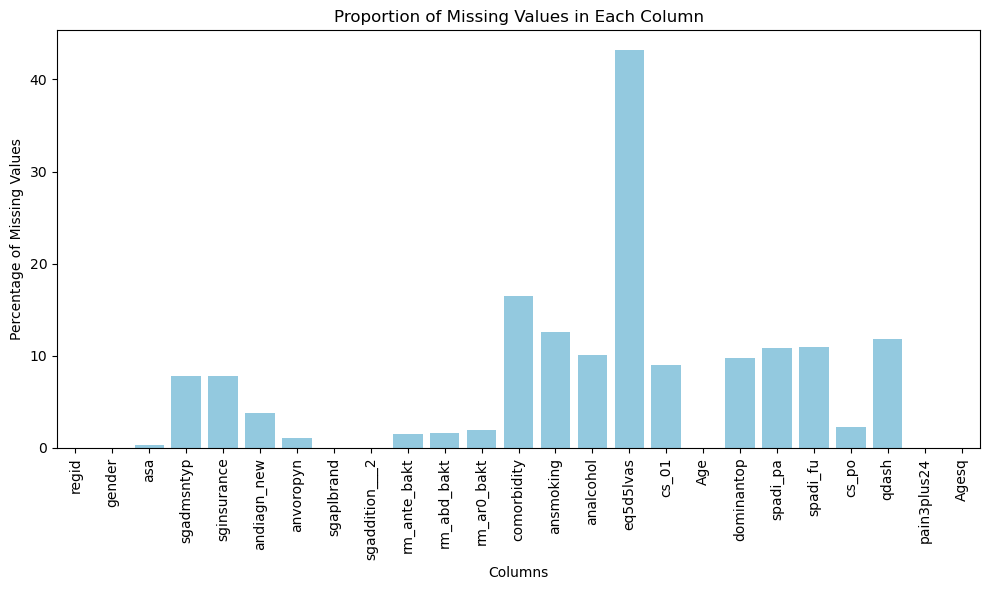

16.45824929407019

In [4]:
missing_report = df.isnull().mean()*100

# Plot the missing values
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_report.index, y=missing_report.values, color='skyblue')
plt.title('Proportion of Missing Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

missing_report.values[12]

In [5]:
# drop unnecessary variables
df = df.drop('regid', axis=1)

#drop variables with more than 20% missing features
df = df.drop('eq5d5lvas', axis=1)

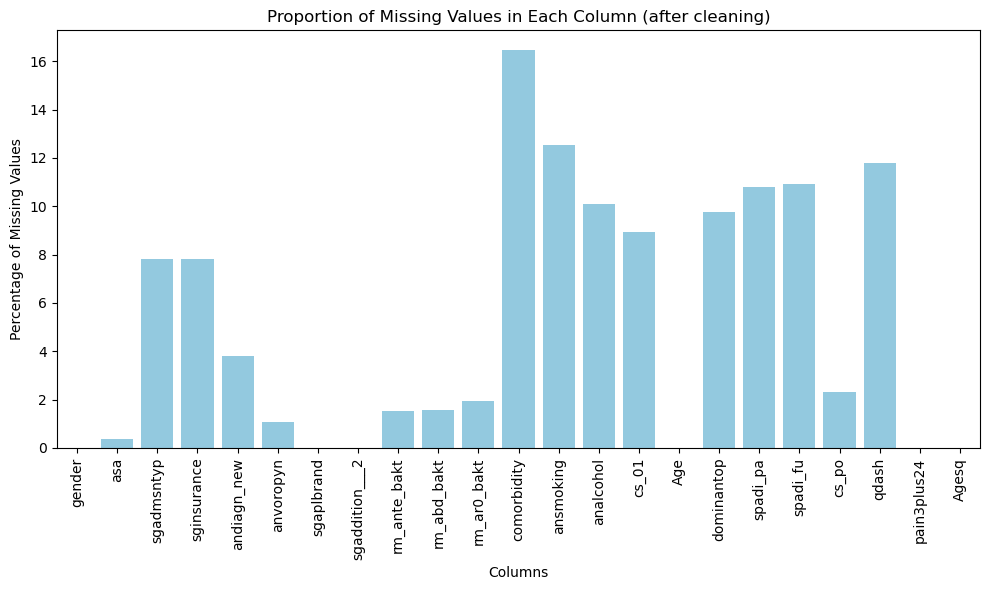

In [6]:
missing_report = df.isnull().mean()*100

# Plot the missing values
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_report.index, y=missing_report.values, color='skyblue')
plt.title('Proportion of Missing Values in Each Column (after cleaning)')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [7]:
df.dropna(inplace=True)
print(df.shape)
df.head()

(1707, 23)


,gender,asa,sgadmsntyp,sginsurance,andiagn_new,anvoropyn,sgaplbrand,sgaddition___2,rm_ante_bakt,rm_abd_bakt,...,analcohol,cs_01,Age,dominantop,spadi_pa,spadi_fu,cs_po,qdash,pain3plus24,Agesq
1,0,3.0,2.0,2.0,1.0,0.0,4,0,50.0,55.0,...,0.0,7.0,83.6,1.0,29.09091,18.181820,0.0,54.5,1,6988.96
3,1,2.0,1.0,3.0,1.0,1.0,4,0,160.0,130.0,...,2.0,4.0,74.9,1.0,40.00000,46.590910,3.0,27.3,0,5610.01
4,0,2.0,2.0,2.0,1.0,1.0,4,0,95.0,85.0,...,1.0,8.0,46.8,1.0,23.63637,56.818180,0.0,45.5,1,2190.24
5,0,3.0,1.0,3.0,1.0,0.0,4,0,110.0,85.0,...,0.0,5.0,81.6,1.0,29.09091,45.454540,0.0,68.2,1,6658.56
6,0,3.0,1.0,2.0,1.0,1.0,4,0,35.0,40.0,...,0.0,8.0,62.7,1.0,14.54546,7.954545,0.0,90.9,1,3931.29


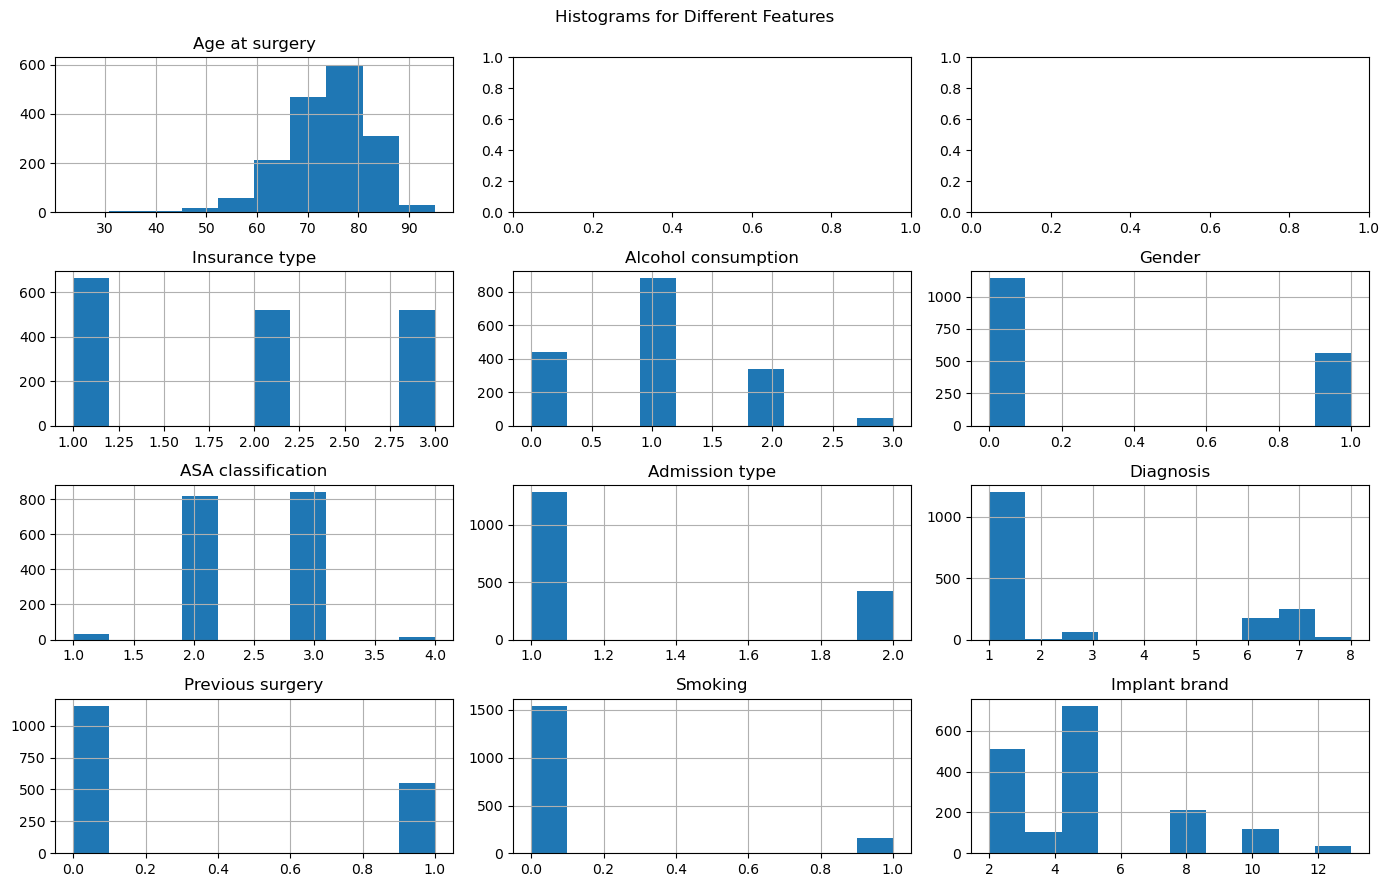

In [8]:
# replace 99 with 12 in sgaplbrand column -> else histogram x axis would go to 99
df['sgaplbrand'].replace(99.0, 12.0 , inplace=True)

# # make subplots for feature histograms
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14, 9))

# # Plot histograms for each column
df['Age'].hist(ax=axes[0,0])
axes[0,0].set_title('Age at surgery')

df['sginsurance'].hist(ax=axes[1,0])
axes[1,0].set_title('Insurance type')

df['analcohol'].hist(ax=axes[1,1])
axes[1,1].set_title('Alcohol consumption')

df['gender'].hist(ax=axes[1,2])
axes[1,2].set_title('Gender')

df['asa'].hist(ax=axes[2,0])
axes[2,0].set_title('ASA classification')

df['sgadmsntyp'].hist(ax=axes[2,1])
axes[2,1].set_title('Admission type')

df['andiagn_new'].hist(ax=axes[2,2])
axes[2,2].set_title('Diagnosis')

df['anvoropyn'].hist(ax=axes[3,0])
axes[3,0].set_title('Previous surgery')

df['ansmoking'].hist(ax=axes[3,1])
axes[3,1].set_title('Smoking')

df['sgaplbrand'].hist(ax=axes[3,2])
axes[3,2].set_title('Implant brand')

plt.suptitle('Histograms for Different Features')

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Display the plot
plt.show()

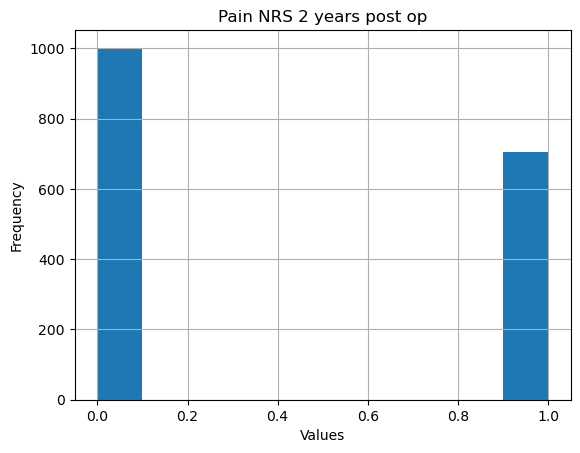

In [9]:
# visualize distribution of target variable
df['pain3plus24'].hist()

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Pain NRS 2 years post op')

# Display the plot
plt.show()

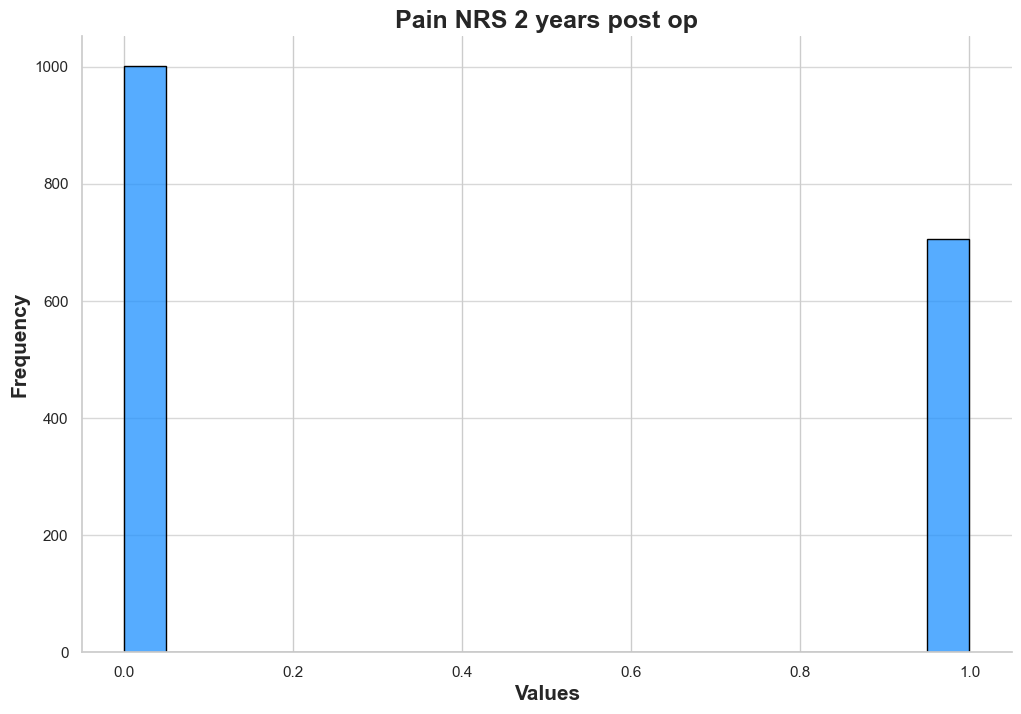

In [10]:
sns.set(style="whitegrid")

# Creating the plot
plt.figure(figsize=(12, 8))
sns.histplot(df['pain3plus24'], bins=20, kde=False, color='dodgerblue', edgecolor='black')

# Add labels and title with custom font size and style
plt.xlabel('Values', fontsize=15, fontweight='bold')
plt.ylabel('Frequency', fontsize=15, fontweight='bold')
plt.title('Pain NRS 2 years post op', fontsize=18, fontweight='bold')

# Adding a grid for better readability
plt.grid(axis='y', alpha=0.75)

# Remove the top and right spines
sns.despine()

# Display the plot
plt.show()

## Preprocessing

In [11]:
# preprocessing, scaling, rounding etc.

df['asa']=df['asa'].astype(int)
df['sgadmsntyp']=df['sgadmsntyp'].astype(int)
df['sginsurance']=df['sginsurance'].astype(int)
df['andiagn_new']=df['andiagn_new'].astype(int)
df['anvoropyn']=df['anvoropyn'].astype(int)
df['comorbidity']=df['comorbidity'].astype(int)
df['ansmoking']=df['ansmoking'].astype(int)
df['analcohol']=df['analcohol'].astype(int)
df['sgaddition___2']=df['sgaddition___2'].astype(int)

# df['analcohol']=df['analcohol'].astype(int)

categorical_columns=['sginsurance', 'sgaplbrand', 'andiagn_new', 'analcohol']
# print(df.columns)

#one hot encoding, drop first column as it is redundant
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True, dtype=int)

# df.head()
df.columns

Index(['gender', 'asa', 'sgadmsntyp', 'anvoropyn', 'sgaddition___2',
       'rm_ante_bakt', 'rm_abd_bakt', 'rm_ar0_bakt', 'comorbidity',
       'ansmoking', 'cs_01', 'Age', 'dominantop', 'spadi_pa', 'spadi_fu',
       'cs_po', 'qdash', 'pain3plus24', 'Agesq', 'sginsurance_2',
       'sginsurance_3', 'sgaplbrand_4', 'sgaplbrand_5', 'sgaplbrand_8',
       'sgaplbrand_10', 'sgaplbrand_12', 'sgaplbrand_13', 'andiagn_new_2',
       'andiagn_new_3', 'andiagn_new_6', 'andiagn_new_7', 'andiagn_new_8',
       'analcohol_1', 'analcohol_2', 'analcohol_3'],
      dtype='object')

In [12]:
#recode some variables. doesn't work with pd.get_dummies

# Define a dictionary for recoding
recode_dict = {1: 0, 2: 1} #Illness: 1->0 Accident: 2->1
# Illness: 0
# Accident: 1
# Recode values using replace()
df['sgadmsntyp'] = df['sgadmsntyp'].replace(recode_dict)

In [13]:
#merge 
df.head()
df.columns

Index(['gender', 'asa', 'sgadmsntyp', 'anvoropyn', 'sgaddition___2',
       'rm_ante_bakt', 'rm_abd_bakt', 'rm_ar0_bakt', 'comorbidity',
       'ansmoking', 'cs_01', 'Age', 'dominantop', 'spadi_pa', 'spadi_fu',
       'cs_po', 'qdash', 'pain3plus24', 'Agesq', 'sginsurance_2',
       'sginsurance_3', 'sgaplbrand_4', 'sgaplbrand_5', 'sgaplbrand_8',
       'sgaplbrand_10', 'sgaplbrand_12', 'sgaplbrand_13', 'andiagn_new_2',
       'andiagn_new_3', 'andiagn_new_6', 'andiagn_new_7', 'andiagn_new_8',
       'analcohol_1', 'analcohol_2', 'analcohol_3'],
      dtype='object')

In [14]:
#save dataset
df.to_csv('predictcs_painbinary24_v2.csv', index=False)  # Set index=False to avoid saving row indices

In [16]:
# train test split
X = df.drop('pain3plus24', axis=1)
y = df[['pain3plus24']]
X.head()

,gender,asa,sgadmsntyp,anvoropyn,sgaddition___2,rm_ante_bakt,rm_abd_bakt,rm_ar0_bakt,comorbidity,ansmoking,...,sgaplbrand_12,sgaplbrand_13,andiagn_new_2,andiagn_new_3,andiagn_new_6,andiagn_new_7,andiagn_new_8,analcohol_1,analcohol_2,analcohol_3
1,0,3,1,0,0,50.0,55.0,40.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2,0,1,0,160.0,130.0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,2,1,1,0,95.0,85.0,40.0,0,1,...,0,0,0,0,0,0,0,1,0,0
5,0,3,0,0,0,110.0,85.0,20.0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,0,3,0,1,0,35.0,40.0,40.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
#convert to numpy array
X1=X.copy()
y1=y.copy()
X=X.values
y=y.values

In [18]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, stratify=y)

# train test split for shap analyis
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=41, stratify=y)

# X_test_shap = X_test.copy()
print('Training Set:')
print(f'X Shape: {X_train.shape}')
print(f'y Shape: {y_train.shape}')
print('Test Set: ')
print(f'X Shape: {X_test.shape}')
print(f'y Shape: {y_test.shape}')
# df.columns

Training Set:
X Shape: (1365, 34)
y Shape: (1365, 1)
Test Set: 
X Shape: (342, 34)
y Shape: (342, 1)


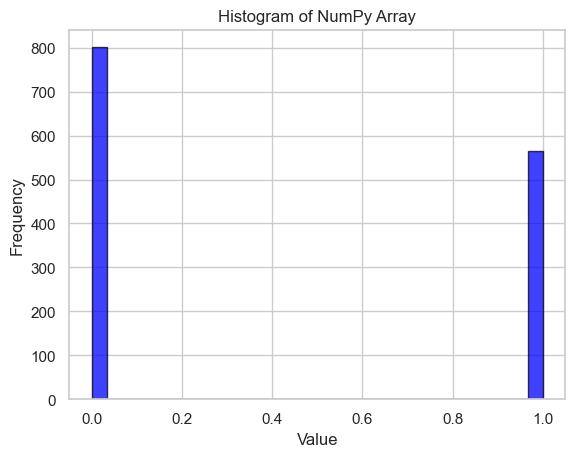

In [19]:
plt.hist(y_train, bins=30, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram of NumPy Array')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

              precision    recall  f1-score   support

           0       0.57      0.57      0.57       201
           1       0.39      0.40      0.39       141

    accuracy                           0.50       342
   macro avg       0.48      0.48      0.48       342
weighted avg       0.50      0.50      0.50       342



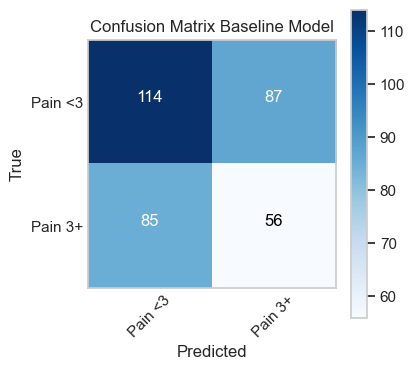

In [20]:
# Baseline model 

dummy_clf = DummyClassifier(strategy='stratified', random_state=42)

# Fit the baseline classifier on the training data
dummy_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_dummy = dummy_clf.predict(X_test)

conf_matrix=metrics.confusion_matrix(y_test, y_pred_dummy)
# conf_matrix=metrics.confusion_matrix(y_train, predictions1)
# Define class labels
class_names = ['Pain <3', 'Pain 3+']

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix Baseline Model')
plt.colorbar()

# # Add labels
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add values inside the squares
# thresh = conf_matrix.max() / 2.
thresh = 70
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")
plt.grid(visible=None)
plt.tick_params(axis=u'both', which=u'both',length=0)

plt.xlabel('Predicted')
plt.ylabel('True')
# plt.show()
plt.savefig('Confusion_matrix_baseline.png', bbox_inches='tight', dpi=300)

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred_dummy)
print(classification_report(y_test, y_pred_dummy))

In [21]:
#normalize and scale data (scale and transform after train/test split!! otherwise there is data leakage from test to training set!)

#scaling continuous and ordinal features
scaler = StandardScaler()

# always fit and transform on training set, just transform on test set
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(1602,)
(1602, 34)


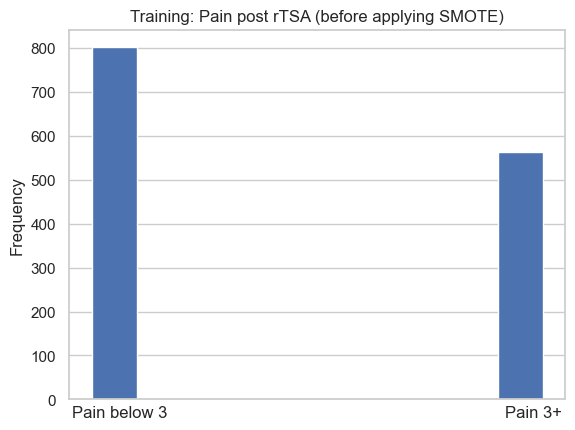

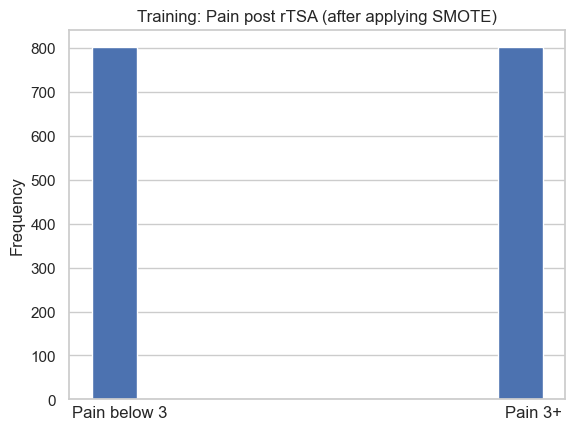

In [22]:
#apply SMOTE to balance dataset
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print(y_res.shape)
print(X_res.shape)
plt.close()
plt.hist(y_train)
plt.xlabel('Pain below 3                                                                         Pain 3+')
plt.ylabel('Frequency')
plt.title('Training: Pain post rTSA (before applying SMOTE)')
plt.xticks([])
plt.show()
plt.hist(y_res)
plt.xlabel('Pain below 3                                                                         Pain 3+')
plt.ylabel('Frequency')
plt.title('Training: Pain post rTSA (after applying SMOTE)')
plt.xticks([])
plt.show()

### -> SMOTE increases trainingset from 1365 to 1602 samples

# Deep Neural Network

In [23]:
#convert features and labels to Float tensors

X_train = torch.FloatTensor(X_res)
y_train = torch.FloatTensor(y_res)

X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test.flatten())

print(X_train.shape)
print(X_test.shape)

torch.Size([1602, 34])
torch.Size([342, 34])


### DataLoader

In [24]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # Convert input features to PyTorch tensor
        self.y = torch.tensor(y, dtype=torch.float32)  # Convert target values to PyTorch tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create instances of the custom dataset
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

# Define parameters for train loader
batch_size = 32
shuffle = True

# Create train loader
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
# trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler_train)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

C:\Users\tim94\AppData\Local\Temp\ipykernel_27992\3958472774.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)  # Convert input features to PyTorch tensor
C:\Users\tim94\AppData\Local\Temp\ipykernel_27992\3958472774.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)  # Convert target values to PyTorch tensor


## Set up Neural Network Architecture

In [25]:
class Classifier(nn.Module):
    
    # input layer = nr of input features --> 
    # h1: hidden layer 1 with n neurons -->
    # h2: hidden layer 2 with m neurons --> 
    # h3: hidden layer 3 with o neurons -->
    # output layer (predicted pain)

    def __init__(self, in_feature=34, h1=128, h2=128, h3=64, out_feature=1):
        super(Classifier, self).__init__()
        self.fc1=nn.Linear(in_feature, h1)
        self.fc2=nn.Linear(h1,h2)
        self.fc3=nn.Linear(h2,h3)
        self.out=nn.Linear(h3, out_feature)
        self.sigmoid=nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.sigmoid(self.out(x))
        
        return x
    
#set seed
torch.manual_seed(41)

In [26]:
# Create an instance of the model
model = Classifier()

# set loss function
criterion = nn.BCELoss()

# set optimizer and set learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# need to re create instance of the model incl. loss function and optimizer if you want to train it from scratch (as opposed to continuing training)

#how many parameters in the model?
n_par=sum(
    param.numel() for param in model.parameters()
)
print(f' number of parameters: {n_par}')

# reset model gradients
def reset_model_parameters(model):
    for param in model.parameters():
        if param.requires_grad:
            nn.init.normal_(param.data, mean=0, std=0.1)  # Reinitialize parameters to random values

# # Reset optimizer
def reset_optimizer(optimizer):
    for group in optimizer.param_groups:
        for param in group['params']:
            param.grad = None  # Clear the gradients

 number of parameters: 29313


In [27]:
# define training function, model is in train mode
def train(model, trainloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for X_train, y_train in trainloader:
        optimizer.zero_grad()  # reset gradients
        y_pred = model.forward(X_train)
        loss = criterion(y_pred.flatten(), y_train)
#         loss = criterion(y_pred, y_train)
        loss.backward()    # compute gradients
        optimizer.step()   # update parameters with gradients
        running_loss += loss.item()
    return running_loss / len(trainloader)

# same as training function, but model is in evaluation mode
def test(model, testloader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad(): #no gradients calculated (already done during training)
        for X_test, y_test in testloader:
            y_eval = model.forward(X_test)
            loss = criterion(y_eval.flatten(), y_test)
#             loss = criterion(y_eval, y_test)
            running_loss += loss.item()
    return running_loss / len(testloader)

In [28]:
# model=LinearRegression()
reset_model_parameters(model)
reset_optimizer(optimizer)

In [29]:
num_epochs = 15
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss = train(model, trainloader, criterion, optimizer)
    test_loss = test(model, testloader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
#     if epoch % 9 == 0:
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/15, Train Loss: 0.6916, Test Loss: 0.6925
Epoch 2/15, Train Loss: 0.6749, Test Loss: 0.6836
Epoch 3/15, Train Loss: 0.6644, Test Loss: 0.6790
Epoch 4/15, Train Loss: 0.6502, Test Loss: 0.6719
Epoch 5/15, Train Loss: 0.6474, Test Loss: 0.6629
Epoch 6/15, Train Loss: 0.6355, Test Loss: 0.6608
Epoch 7/15, Train Loss: 0.6254, Test Loss: 0.6554
Epoch 8/15, Train Loss: 0.6286, Test Loss: 0.6568
Epoch 9/15, Train Loss: 0.6182, Test Loss: 0.6537
Epoch 10/15, Train Loss: 0.6132, Test Loss: 0.6509
Epoch 11/15, Train Loss: 0.6051, Test Loss: 0.6520
Epoch 12/15, Train Loss: 0.5947, Test Loss: 0.6499
Epoch 13/15, Train Loss: 0.6085, Test Loss: 0.6459
Epoch 14/15, Train Loss: 0.6008, Test Loss: 0.6453
Epoch 15/15, Train Loss: 0.5922, Test Loss: 0.6415


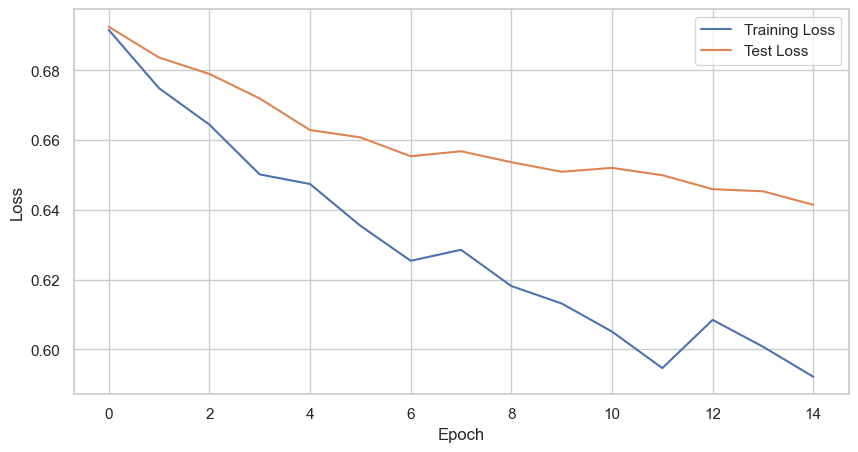

In [30]:
# Plotting losses
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(num_epochs), train_losses, label='Training Loss')
ax.plot(range(num_epochs), test_losses, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
plt.show()

In [31]:
# train predictions and real values
y_pred=model.forward(X_train)
y_actual_train=y_train.detach().numpy()
y_predicted_train=y_pred.detach().numpy()

In [32]:
# test predictions and real values
y_eval=model.forward(X_test)
y_actual_test=y_test.detach().numpy()
y_predicted_test=y_eval.detach().numpy()

In [33]:
y_predicted_test=y_predicted_test.round()
y_predicted_train=y_predicted_train.round()

In [34]:
# print(y_eval[1],y_test[1])
print(f'Predicted Value 233: {y_eval[233]}, Actual Value 233: {y_test[233]}')

Predicted Value 233: tensor([0.3266], grad_fn=<SelectBackward0>), Actual Value 233: 0.0


In [35]:
# confusion matrix!!
predictions1=y_predicted_train
predictions2=y_predicted_test

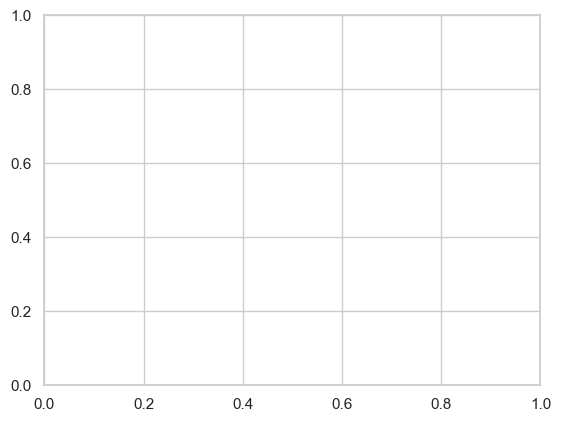

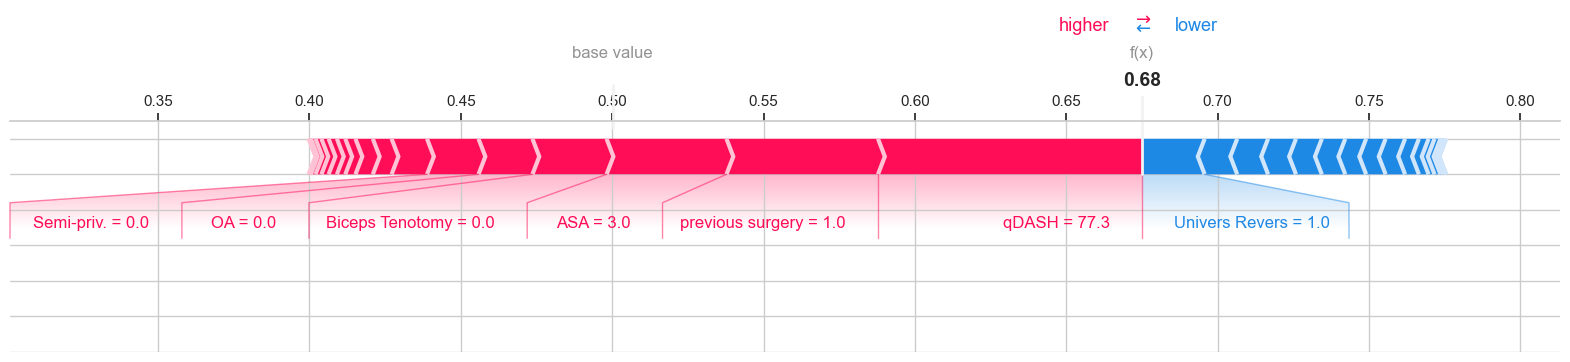

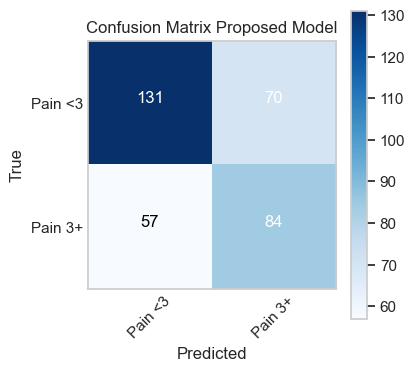

              precision    recall  f1-score   support

         0.0     0.6968    0.6517    0.6735       201
         1.0     0.5455    0.5957    0.5695       141

    accuracy                         0.6287       342
   macro avg     0.6211    0.6237    0.6215       342
weighted avg     0.6344    0.6287    0.6306       342

Accuracy: 0.629
[[131  70]
 [ 57  84]]



In [59]:
conf_matrix=metrics.confusion_matrix(y_test, predictions2)
# Define class labels
class_names = ['Pain <3', 'Pain 3+']

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix Proposed Model')
plt.colorbar()

# # Add labels
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add values inside the squares
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")
plt.grid(visible=None)
plt.tick_params(axis=u'both', which=u'both',length=0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.savefig('Confusion_matrix_proposed_model.png', bbox_inches='tight', dpi=300)

print(classification_report(y_test, predictions2,digits=4))
print(f'Accuracy: {round(accuracy_score(y_test, predictions2),3)}')
print(conf_matrix)

print("")

## SHAP Feature Importance

In [37]:
import shap

In [38]:
X_train_np = X_train.numpy()
X_test_np = X_test.numpy()
torch.set_grad_enabled(True)

In [39]:
e = shap.DeepExplainer(model, X_train)

In [40]:
shap_values = e.shap_values(
    torch.from_numpy(X_test_np), check_additivity=False
)

In [41]:
print(type(shap_values))
print(shap_values.shape)
shap_values2d = shap_values.reshape(-2, shap_values.shape[-2])
print(shap_values2d.shape)

<class 'numpy.ndarray'>
(342, 34, 1)
(342, 34)


In [43]:
features=X1.columns

df = pd.DataFrame({
    "mean_abs_shap": np.mean(np.abs(shap_values2d), axis=0), 
    "stdev_abs_shap": np.std(np.abs(shap_values2d), axis=0), 
    "name": features
})
df.sort_values("mean_abs_shap", ascending=False)[:35]
X1.columns
features=['Sex', 'ASA', 'Admission Type', 'Previous Surgery', 'Biceps Tenotomy', 'Flexion',
       'Abduction', 'External Rotation', 'Comorbidity', 'Smoking',
       'Pain NRS', 'Age', 'dominant Side treated', 'SPADI Pain Subscore', 'SPADI Function Subscore', 'CS Power Subscore', 'quickDASH', 'Age (squared)',
       'Semi-private Insurance', 'Private Insurance', 'Lima Reverse', 'Univers Revers',
       'Aequalis Reversed II', 'Ascend Flex Reverse', 'PERFORM humeral reversed', 'Other rTSA',
       'Osteoarthritis due to Instability', 'Rheumatoid Arthritis', 'Fracture Sequelae', 'Primary OA',
       'Primary Humeral Head Necrosis' , 'Alcohol occasionally','Alcohol daily','Alcohol several times a day']

,mean_abs_shap,stdev_abs_shap,name
0,0.010905,0.003329,gender
1,0.043405,0.011305,asa
2,0.013723,0.009655,sgadmsntyp
3,0.027291,0.016638,anvoropyn
4,0.027263,0.004391,sgaddition___2
5,0.005519,0.004762,rm_ante_bakt
6,0.008696,0.008922,rm_abd_bakt
7,0.006487,0.005231,rm_ar0_bakt
8,0.003652,0.001531,comorbidity
9,0.016222,0.019903,ansmoking


In [48]:
plt.close()
plt.grid(False)
shap.summary_plot(shap_values2d, X_test, features, show=False, max_display=9)
plt.title("Prediction-driving Features")
plt.savefig('shap_summary_plot.png', dpi=300)
plt.close()

In [58]:
# df anpassen für force plots beschriftung
X1_test.rename(columns={"asa": "ASA", "andiagn_new_7": "OA", "sginsurance_2": "Semi-priv.", "qdash": "qDASH", "sgaddition___2": "Biceps Tenotomy", "sgaplbrand_5": "Univers Revers", "anvoropyn": "previous surgery", "cs_01": "Pain", "rm_abd_bakt": "Abduction", "spadi_fu": "SPADI Funct."}, inplace=True)
X1_test['SPADI Funct.']=X1_test['SPADI Funct.'].round(1)
# X1_test.iloc[5,:]


In [64]:
plt.close()
sns.set_style("whitegrid", {'axes.grid' : False})
plt.grid(True)
k = 142
shap.force_plot(e.expected_value, shap_values2d[k], X1_test.iloc[k,:], matplotlib=True, show=False)
# 339, 158 für pain
# 142, 104, 22, 48 für no pain
plt.savefig('shap_pat142_neg.png', bbox_inches = 'tight', dpi=300)
# plt.savefig('shap_pat339_pos.png')